In [1]:
!pip install tf-nightly

In [ ]:
import tensorflow as tf
tf.__version__

In [4]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split

import tensorflow.keras as keras
from tensorflow.keras import applications
from tensorflow.keras.layers import Flatten, LeakyReLU, Dense
from tensorflow.keras.models import *
from tensorflow.keras import optimizers
from tensorflow.keras.callbacks import ReduceLROnPlateau, EarlyStopping
import random
import matplotlib.pyplot as plt
from tensorflow import keras
from tensorflow.keras import layers
import tensorflow as tf


from tensorflow.keras.preprocessing.image import load_img
from tensorflow.keras.preprocessing.image import img_to_array

from os import listdir
from os.path import isfile, join

# training data
image_size = 224
labels = pd.read_csv("data/fgvc7/train.csv")
image_dir = "data/fgvc7/images"

In [5]:
# import image data and combine labels
def load_data(dataset='Train',image_dir= 'data/fgvc7/images'):
    X = []
    y = []
    for f in listdir(image_dir):
        if isfile(join(image_dir, f)) and f[:len(dataset)]==dataset:
            # add filename
            #train_list.append(f)
            # add image to the list
            img = load_img(f'{image_dir}/{f}', target_size=(image_size,image_size,3))
            img_array = img_to_array(img, dtype='uint8')
            # Get id
            id = int(f[len(dataset)+1:-4])
            X.append(img_array)
            if dataset=='Train':
                y.append(labels.iloc[id][['healthy', 'multiple_diseases', 'rust', 'scab']].to_numpy())
            else:
                y.append([f[:-4], id])
    if dataset=='Train':
        y = np.array(y, dtype=np.uint16)   
    return np.array(X, dtype=np.uint16), y

In [6]:
# import training data and combine labels
data_x, data_y  = load_data() 

## Augmentation

In [12]:
import imgaug.augmenters as iaa
seq = iaa.Sequential([
    iaa.SomeOf((0,2),[
        iaa.Identity(),
        iaa.AverageBlur(k=((3, 5), (5, 7))),
        iaa.Rotate((-45,45)),
        iaa.Affine(scale=(0.5, 0.95)),    
        iaa.Multiply((0.50, 1.1))
        #,iaa.BlendAlphaRegularGrid(nb_rows=(4, 6), nb_cols=(1, 4),
        #                        foreground=iaa.Multiply(0.0))
        #,iaa.Cartoon()
        ,iaa.Cutout(nb_iterations=(1, 3), size=0.2, squared=False, cval=0)
        ,iaa.Affine(shear=(-48, 48))
        ,iaa.Affine(translate_px={"x": (-42, 42), "y": (-36, 36)})
        ,iaa.KeepSizeByResize(iaa.Resize({"height": (0.70, 0.90), "width": (0.70, 0.90)}))
        ,iaa.CropAndPad(percent=(-0.2, 0.2))
        #,iaa.PiecewiseAffine(scale=(0.01, 0.05))
        ,iaa.PerspectiveTransform(scale=(0.01, 0.1))
        #,iaa.WithPolarWarping(iaa.CropAndPad(percent=(-0.1, 0.1)))
        #,iaa.ElasticTransformation(alpha=(0, 3.0), sigma=0.5)
       ])
    #,iaa.SaveDebugImageEveryNBatches(folder_path, 100)    
], random_order=True)

In [13]:
def generator(features, labels, batch_size):
    while True:
        # Fill arrays of batch size with augmented data taken randomly from full passed arrays
        indexes = random.sample(range(len(features)), batch_size)
      
        # Transform X and y
        x_aug = seq(images =features[indexes])
        yield np.array(x_aug), np.array(labels[indexes])

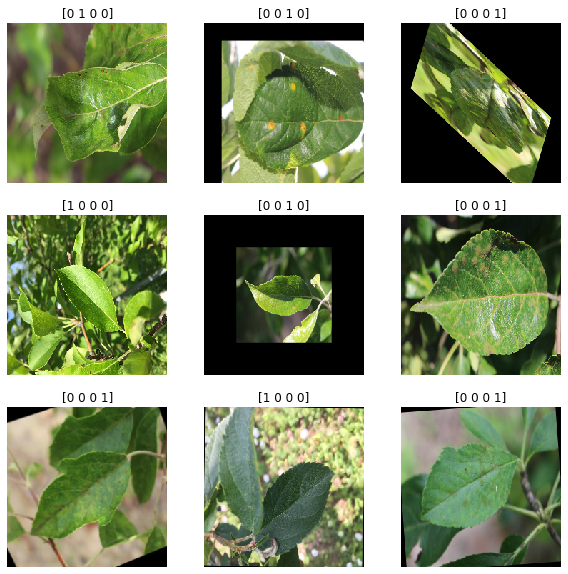

In [14]:
images = generator(data_x,data_y, 9)
image = next(images)

plt.figure(figsize=(10, 10))
for i in range(9):
    ax = plt.subplot(3, 3, i + 1)
    #augmented_image = seq(images = x_train[:1])
    plt.imshow(image[0][i])
    plt.title(str(image[1][i]))
    plt.axis("off")

## Transfer Learning

In [15]:
x_train, x_val, y_train, y_val = train_test_split(data_x, data_y, test_size=0.20, random_state=42)
y_train = np.argmax(y_train,axis=1)
y_val = np.argmax(y_val,axis=1)

In [16]:
base_model = EfficientNetB7(
    weights='imagenet',
    input_shape=(image_size, image_size, 3),
    include_top=False)

In [17]:
# Create new model on top.
inputs = keras.Input(shape=(image_size, image_size, 3))
x = base_model(inputs, training=False)
x = keras.layers.GlobalAveragePooling2D()(x)
outputs = keras.layers.Dense(4)(x)
model = keras.Model(inputs, outputs)
model.summary()

Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_3 (InputLayer)         [(None, 224, 224, 3)]     0         
_________________________________________________________________
efficientnetb7 (Functional)  (None, 7, 7, 2560)        64097687  
_________________________________________________________________
global_average_pooling2d (Gl (None, 2560)              0         
_________________________________________________________________
dense (Dense)                (None, 4)                 10244     
Total params: 64,107,931
Trainable params: 63,797,204
Non-trainable params: 310,727
_________________________________________________________________


In [18]:
# Warm up head
adam = optimizers.Adam(learning_rate=0.0005)
#lr_scheduler = tf.keras.callbacks.LearningRateScheduler(scheduler)
reduce_lr = ReduceLROnPlateau(monitor='val_loss', 
                           factor=0.2,  
                           patience=3, 
                           min_lr=0.00005)
early_stop = EarlyStopping(
    monitor='val_loss', 
    min_delta=0, 
    patience=6, 
    verbose=0, 
    mode='auto',
    baseline=None, 
    restore_best_weights=True
)

batch_size = 64
#num_warmup_steps = 5

# freeze pretrained weights
model.layers[1].trainable = False

model.compile(optimizer=adam, 
              loss=tf.keras.losses.SparseCategoricalCrossentropy(),
              metrics=[tf.keras.metrics.SparseCategoricalCrossentropy()])


history = model.fit(generator(x_train, y_train, batch_size),  
                    shuffle=True,  
                    validation_data = (x_val, y_val),
                    callbacks = [reduce_lr,early_stop],                        
                    epochs=100,
                    steps_per_epoch=len(x_train)/batch_size ,
                    verbose=True
                   )
print(model.optimizer.lr)

Epoch 1/100
22/22 [==============================] - 182s 7s/step - loss: 3.4338 - sparse_categorical_crossentropy: 3.4338 - val_loss: 1.5434 - val_sparse_categorical_crossentropy: 1.5434
Epoch 2/100
22/22 [==============================] - 163s 7s/step - loss: 1.9448 - sparse_categorical_crossentropy: 1.9448 - val_loss: 1.5059 - val_sparse_categorical_crossentropy: 1.5059
Epoch 3/100
22/22 [==============================] - 163s 7s/step - loss: 1.8446 - sparse_categorical_crossentropy: 1.8446 - val_loss: 1.6881 - val_sparse_categorical_crossentropy: 1.6881
Epoch 4/100
22/22 [==============================] - 163s 7s/step - loss: 1.8531 - sparse_categorical_crossentropy: 1.8531 - val_loss: 1.4067 - val_sparse_categorical_crossentropy: 1.4067
Epoch 5/100
22/22 [==============================] - 163s 7s/step - loss: 1.9380 - sparse_categorical_crossentropy: 1.9380 - val_loss: 1.3090 - val_sparse_categorical_crossentropy: 1.3090
Epoch 6/100
22/22 [==============================] - 162s 7s

In [19]:
# Train entire network
adam = optimizers.Adam(learning_rate=0.0001)
#lr_scheduler = tf.keras.callbacks.LearningRateScheduler(scheduler)
reduce_lr = ReduceLROnPlateau(monitor='val_accuracy', 
                           factor=0.2,  
                           patience=5 , 
                           min_lr=0.00001)
early_stop = EarlyStopping(
    monitor='val_accuracy', 
    min_delta=0, 
    patience=10, 
    verbose=0, 
    mode='auto',
    baseline=None, 
    restore_best_weights=True
)

# freeze pretrained weights
model.layers[1].trainable = True

model.compile(optimizer=adam, 
              loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
              metrics=['accuracy'])

history2 = model.fit(generator(x_train, y_train, batch_size),  
                    shuffle=True,  
                    validation_data = (x_val, y_val),
                    callbacks = [reduce_lr,early_stop],                        
                    epochs=200,
                    steps_per_epoch=len(x_train)/batch_size ,
                    verbose=True
                   )

Epoch 1/200
22/22 [==============================] - 632s 27s/step - loss: 0.6634 - accuracy: 0.7850 - val_loss: 0.3019 - val_accuracy: 0.9151
Epoch 2/200
22/22 [==============================] - 599s 26s/step - loss: 0.2190 - accuracy: 0.9308 - val_loss: 0.2707 - val_accuracy: 0.9315
Epoch 3/200
22/22 [==============================] - 600s 26s/step - loss: 0.1214 - accuracy: 0.9658 - val_loss: 0.2404 - val_accuracy: 0.9178
Epoch 4/200
22/22 [==============================] - 599s 26s/step - loss: 0.0563 - accuracy: 0.9860 - val_loss: 0.2374 - val_accuracy: 0.9260
Epoch 5/200
22/22 [==============================] - 602s 27s/step - loss: 0.0531 - accuracy: 0.9834 - val_loss: 0.2926 - val_accuracy: 0.9233
Epoch 6/200
22/22 [==============================] - 599s 26s/step - loss: 0.0732 - accuracy: 0.9786 - val_loss: 0.2147 - val_accuracy: 0.9370
Epoch 7/200
22/22 [==============================] - 600s 26s/step - loss: 0.0320 - accuracy: 0.9887 - val_loss: 0.2404 - val_accuracy: 0.9479

In [20]:
model.save('models/xception')

INFO:tensorflow:Assets written to: models/xception/assets


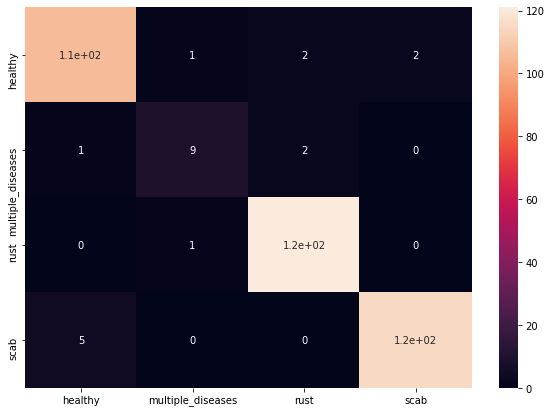

In [21]:
from sklearn.metrics import confusion_matrix
import seaborn as sn
import pandas as pd
import matplotlib.pyplot as plt

labels = ['healthy', 'multiple_diseases', 'rust', 'scab']
y_val_pred = np.argmax(model.predict(x_val), axis=1)
mat = confusion_matrix(y_val, y_val_pred)

df_cm = pd.DataFrame(mat, index = [i for i in labels],
                  columns = [i for i in labels])
plt.figure(figsize = (10,7))
sn.heatmap(df_cm, annot=True)

In [22]:
# Train on all data before inference
model.fit(generator(x_val, y_val, batch_size),            
                    epochs=2,
                    steps_per_epoch=len(x_train)/batch_size ,
                    verbose=True
                   )

Epoch 1/2
22/22 [==============================] - 569s 25s/step - loss: 0.1355 - accuracy: 0.9667
Epoch 2/2
22/22 [==============================] - 568s 25s/step - loss: 0.0629 - accuracy: 0.9823


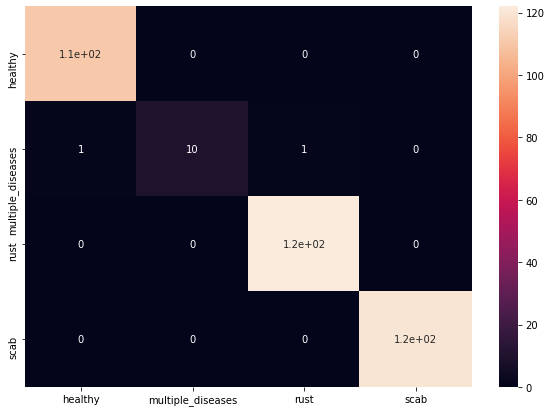

In [23]:
from sklearn.metrics import confusion_matrix
import seaborn as sn
import pandas as pd
import matplotlib.pyplot as plt

labels = ['healthy', 'multiple_diseases', 'rust', 'scab']
y_val_pred = np.argmax(model.predict(x_val), axis=1)
mat = confusion_matrix(y_val, y_val_pred)

df_cm = pd.DataFrame(mat, index = [i for i in labels],
                  columns = [i for i in labels])
plt.figure(figsize = (10,7))
sn.heatmap(df_cm, annot=True)

In [24]:
# Load test data and their filename for submission file
test_x, test_id  = load_data("Test") 
test_y = model.predict(test_x)
test_pred = tf.nn.softmax(test_y).numpy()
test_set = np.hstack((test_id, test_pred))
test_set = test_set[test_set[:,1].astype('uint16').argsort()]
test_DF = pd.DataFrame(test_set, index=test_set[:,1], columns=["image_id","id","healthy","multiple_diseases","rust","scab"])
test_DF[["image_id","healthy","multiple_diseases","rust","scab"]].to_csv('submissions/xception.csv', index=False)

In [25]:
!kaggle competitions submit -f 'submissions/xception.csv' -m"xception baseline 20210130" plant-pathology-2020-fgvc7

100%|█████████████████████████████████████████| 104k/104k [00:00<00:00, 241kB/s]
Successfully submitted to Plant Pathology 2020 - FGVC7

In [26]:
!kaggle competitions submissions plant-pathology-2020-fgvc7

fileName               date                 description                   status    publicScore  privateScore  
---------------------  -------------------  ----------------------------  --------  -----------  ------------  
xception.csv           2021-02-06 07:19:59  xception baseline 20210130    complete  0.94455      0.91202       
xception.csv           2021-02-06 04:18:08  xception baseline 2021-02-06  complete  0.88840      0.87141       
NASNet.csv             2021-01-31 19:49:33  NAXNet baseline 20210131      complete  0.91386      0.90567       
xception.csv           2021-01-31 16:12:55  xception baseline 20210130    complete  0.88840      0.87141       
inceptionResNetv2.csv  2021-01-31 02:36:15  inception baseline 20210130   complete  0.92493      0.93380       


#### 0.9338 is #801 on leaderboard

## Convert to TFLite

In [27]:
# Convert the model
converter = tf.lite.TFLiteConverter.from_saved_model("models/xception") # path to the SavedModel directory
tflite_model = converter.convert()

# Save the model.
with open('models/xception.tflite', 'wb') as f:
    f.write(tflite_model)

In [28]:
import cv2
for i in range(5):
    index = np.random.randint(len(x_train))
    print(f"====TF Model result{index}====")
    print(model.predict(np.expand_dims(x_train[index],axis=0)))
    print(y_train[index])

    interpreter = tf.lite.Interpreter(model_path="models/xception.tflite")
    interpreter.allocate_tensors()
    # Get input and output tensors.
    input_details = interpreter.get_input_details()
    output_details = interpreter.get_output_details()

    # Test the model on random input data.
    input_shape = input_details[0]['shape']

    img = cv2.resize(x_train[index], (image_size,image_size)).astype('float32')

    input_data = np.expand_dims(img, axis = 0)
    interpreter.set_tensor(input_details[0]['index'], input_data)

    interpreter.invoke()

    # The function `get_tensor()` returns a copy of the tensor data.
    # Use `tensor()` in order to get a pointer to the tensor.
    output_data = interpreter.get_tensor(output_details[0]['index'])
    print("====TFLite result====")
    print(output_data)
    print(np.argmax(output_data))

====TF Model result118====
[[-5.5913553   0.10580774 -4.789981   10.428146  ]]
3
====TFLite result====
[[-6.151669   0.3389328 -5.203408  11.086818 ]]
3
====TF Model result529====
[[-1.854001  -1.206874   5.5994477 -3.6847982]]
2
====TFLite result====
[[-4.0978193 -1.6762551  9.454673  -6.213326 ]]
2
====TF Model result860====
[[-2.7240992 -1.0839779  5.8567367 -2.9417467]]
2
====TFLite result====
[[-5.7429442 -2.8852344 11.931892  -5.623218 ]]
2
====TF Model result691====
[[-2.3256586   0.12409084  3.7397826  -1.7892648 ]]
2
====TFLite result====
[[-5.9245753 -1.6625859 10.673811  -4.3376884]]
2
====TF Model result1246====
[[ 5.682509  -2.1599436 -2.9038138 -3.121694 ]]
0
====TFLite result====
[[ 5.380403  -2.773593  -2.660941  -4.1204834]]
0
